# Quantum circuit analysis (PennyLane)
Exploring the PennyLane circuit used in `build_quantum_layer` (AngleEmbedding + BasicEntanglerLayers), focusing on states, density matrices, purity, entanglement of formation, and interactive exploration.

In [24]:
!pip install pennylane
# Imports and plotting defaults
import numpy as np
import pennylane as qml
import matplotlib.pyplot as plt
from matplotlib import cm
import ipywidgets as widgets
from ipywidgets import interact

# %matplotlib inline  # Uncomment if running in a fresh notebook
plt.style.use("seaborn-v0_8-colorblind")
np.set_printoptions(precision=3, suppress=True)


## Utility helpers
- `sample_random_params` to draw reproducible inputs and weights.
- Basis label helper for pretty axis ticks.
- Density-matrix plotting helper.

In [29]:
# Random parameter sampler matching the layer signature
# Inputs are phases in [0, 2pi); weights live in [-1, 1]
def sample_random_params(n_qubits: int, q_depth: int, seed: int | None = None):
    rng = np.random.default_rng(seed)
    inputs = rng.uniform(0.0, 2 * np.pi, size=(n_qubits,))
    weights = rng.uniform(-1.0, 1.0, size=(q_depth, n_qubits))
    return inputs, weights


def computational_basis_labels(n_qubits: int):
    # Returns binary strings: 00, 01, ... for labeling axes
    return [format(i, f"0{n_qubits}b") for i in range(2**n_qubits)]


def plot_density_matrix(rho: np.ndarray, title_prefix: str = ""):
    """
    Render Re/Im parts of a density matrix as 3D bar plots.
    Accepts numpy arrays (or PennyLane returns) of shape (2^n, 2^n).
    """
    rho = np.array(rho)
    dim = rho.shape[0]
    n_qubits = int(np.log2(dim))
    labels = computational_basis_labels(n_qubits)

    x_positions, y_positions = np.meshgrid(np.arange(dim), np.arange(dim))
    x = x_positions.flatten()
    y = y_positions.flatten()

    fig = plt.figure(figsize=(12, 5))
    parts = [(rho.real, "Re"), (rho.imag, "Im")]
    for idx, (part, name) in enumerate(parts, start=1):
        ax = fig.add_subplot(1, 2, idx, projection="3d")
        ax.bar3d(x, y, np.zeros_like(x), 0.8, 0.8, part.flatten(), shade=True)
        ax.set_xticks(range(dim))
        ax.set_yticks(range(dim))
        ax.set_xticklabels(labels)
        ax.set_yticklabels(labels)
        ax.set_xlabel("Column (ket)")
        ax.set_ylabel("Row (bra)")
        ax.set_zlabel(f"{name}(rho)")
        ax.set_title(f"{title_prefix}{name} of density matrix")

    plt.tight_layout()
    plt.show()


## Build analysis-only QNode
Wraps the same embedding + entangler stack used by `build_quantum_layer`, but returns full state or density matrix for inspection.

In [26]:
# QNode builder mirroring build_quantum_layer logic

def build_analysis_qnode(n_qubits: int, q_depth: int, return_type: str = "state"):
    dev = qml.device("default.qubit", wires=n_qubits)

    @qml.qnode(dev)
    def circuit(inputs, weights):
        qml.AngleEmbedding(inputs, wires=range(n_qubits))
        qml.BasicEntanglerLayers(weights, wires=range(n_qubits))
        if return_type == "state":
            return qml.state()
        if return_type == "density_matrix":
            return qml.density_matrix(wires=range(n_qubits))
        raise ValueError(f"Unknown return_type: {return_type}")

    return circuit


## Circuit drawing demo (ASCII + Matplotlib)Generate a small random instance to inspect the gate pattern.

ASCII circuit diagram (templates):
0: ─╭AngleEmbedding(M0)─╭BasicEntanglerLayers(M1)─┤  State
1: ─╰AngleEmbedding(M0)─╰BasicEntanglerLayers(M1)─┤  State

M0 = 
[4.002 1.695]
M1 = 
[[-0.918 -0.967]
 [ 0.627  0.826]
 [ 0.213  0.459]]


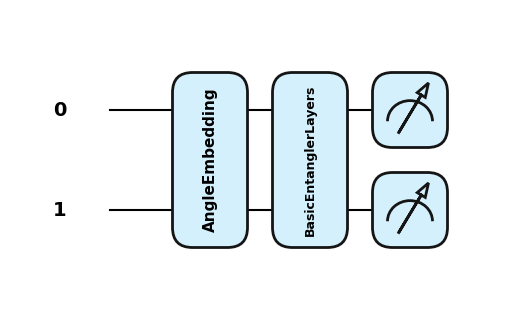


ASCII decomposed circuit (basic gates):
0: ──RX(4.00)──RX(-0.92)─╭●──RX(0.63)─╭●──RX(0.21)─╭●─┤  State
1: ──RX(1.70)──RX(-0.97)─╰X──RX(0.83)─╰X──RX(0.46)─╰X─┤  State


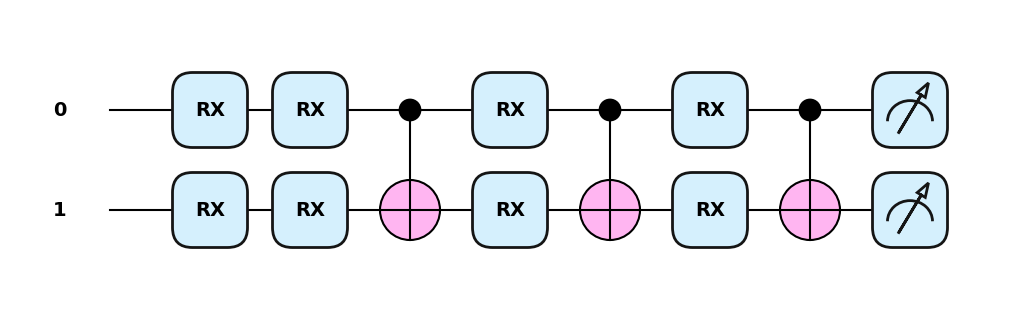

In [27]:
def draw_circuit_example(
    n_qubits: int = 2,
    q_depth: int = 2,
    seed: int | None = None,
    style: str = "pennylane",
):
    inputs, weights = sample_random_params(n_qubits, q_depth, seed=seed)
    qnode = build_analysis_qnode(n_qubits, q_depth, return_type="state")

    # Run once so PennyLane builds the tape
    _ = qnode(inputs, weights)

    # ====== 1) High-level circuit (templates) ======
    print("ASCII circuit diagram (templates):")
    print(qml.draw(qnode)(inputs, weights))

    try:
        drawer = qml.draw_mpl(qnode, expansion_strategy="device", style=style)
        fig, ax = drawer(inputs, weights)
        # ax.set_title(f"Matplotlib circuit visualization (templates, style='{style}')")
        plt.show()
    except Exception as exc:
        print(f"Matplotlib draw (templates) failed: {exc}")

    # ====== 2) Decomposed circuit (basic gates) ======
    decomp_qnode = qml.transforms.decompose(
        qnode,
        gate_set={qml.RX, qml.RY, qml.RZ, qml.CNOT},
    )

    _ = decomp_qnode(inputs, weights)

    print("\nASCII decomposed circuit (basic gates):")
    print(qml.draw(decomp_qnode)(inputs, weights))

    try:
        decomp_drawer = qml.draw_mpl(decomp_qnode, expansion_strategy="device", style=style)
        fig2, ax2 = decomp_drawer(inputs, weights)
        # ax2.set_title(f"Matplotlib circuit visualization (decomposed, style='{style}')")
        plt.show()
    except Exception as exc:
        print(f"Matplotlib draw (decomposed) failed: {exc}")



# Run a quick demo
_ = draw_circuit_example(n_qubits=2, q_depth=3, seed=0)


## Density matrix, purity, and visualizationCompute ? from the circuit, print it, plot Re/Im parts, and report purity.

Density matrix (complex):
[[ 0.092+0.j     0.055+0.013j  0.039+0.273j -0.062-0.01j ]
 [ 0.055-0.013j  0.034+0.j     0.062+0.157j -0.039+0.003j]
 [ 0.039-0.273j  0.062-0.157j  0.83 +0.j    -0.055+0.182j]
 [-0.062+0.01j  -0.039-0.003j -0.055-0.182j  0.043+0.j   ]]
Purity: 1.000


/tmp/ipython-input-3387868941.py:43: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


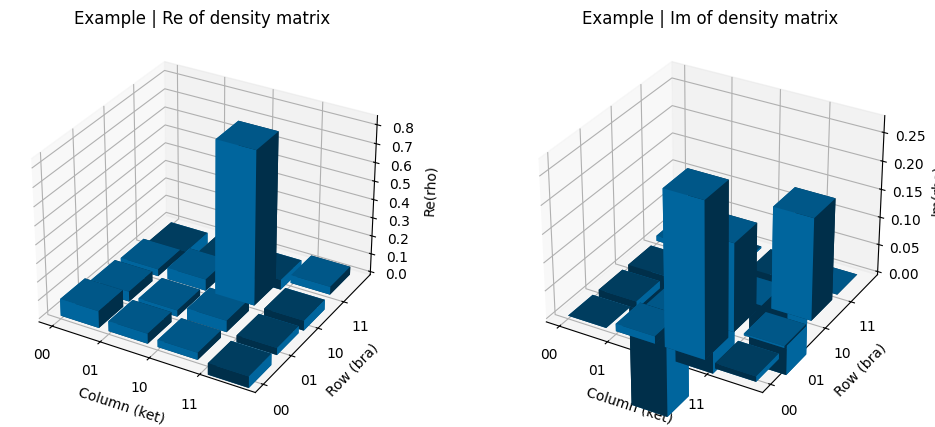

In [30]:
# Purity helper and demo

def compute_density_and_purity(n_qubits: int, q_depth: int, inputs, weights):
    qnode = build_analysis_qnode(n_qubits, q_depth, return_type="density_matrix")
    rho = qnode(inputs, weights)
    purity = float(np.trace(rho @ rho).real)
    return rho, purity


# Example run for 2 qubits
demo_inputs, demo_weights = sample_random_params(2, 2, seed=1)
rho_example, purity_example = compute_density_and_purity(2, 2, demo_inputs, demo_weights)

print("Density matrix (complex):")
print(rho_example)
print(f"Purity: {purity_example:.3f}")

plot_density_matrix(rho_example, title_prefix="Example | ")


## Entanglement of formation (two qubits)Implements Wootters concurrence formula for 2-qubit mixed states.

In [31]:
# Entanglement of formation for two qubits via concurrence

def entanglement_of_formation_two_qubits(rho_2q: np.ndarray) -> float:
    rho = np.array(rho_2q, dtype=complex)
    if rho.shape != (4, 4):
        raise ValueError("rho_2q must be a 4x4 matrix for two qubits")

    sigma_y = np.array([[0, -1j], [1j, 0]])
    Y = np.kron(sigma_y, sigma_y)

    rho_tilde = Y @ rho.conj() @ Y
    R = rho @ rho_tilde
    eigenvals = np.linalg.eigvals(R)
    eigenvals = np.real_if_close(eigenvals)
    eigenvals = np.sqrt(np.maximum(eigenvals, 0))  # numerical guard
    eigenvals = np.sort(eigenvals)[::-1]

    concurrence = max(0.0, float(eigenvals[0] - eigenvals[1] - eigenvals[2] - eigenvals[3]))
    if concurrence <= 0:
        return 0.0

    z = (1 + np.sqrt(1 - concurrence**2)) / 2
    eof = -z * np.log2(z) - (1 - z) * np.log2(1 - z)
    return float(np.real(eof))


# Demo on a random 2-qubit state from the circuit
rnd_inputs, rnd_weights = sample_random_params(2, 3, seed=7)
rho_2q, purity_2q = compute_density_and_purity(2, 3, rnd_inputs, rnd_weights)

print(f"Purity (2-qubit demo): {purity_2q:.4f}")
print(f"Entanglement of formation: {entanglement_of_formation_two_qubits(rho_2q):.4f}")


Purity (2-qubit demo): 1.0000
Entanglement of formation: 0.1942


## Interactive exploration (ipywidgets)
Use sliders to vary qubit count, depth, and random seed. For each selection:
1. Draw the circuit (ASCII + Matplotlib if supported).
2. Compute rho, plot Re/Im parts, report purity.
3. If two qubits, also report entanglement of formation.

In [32]:
# Interactive circuit explorer

def explore_circuit(n_qubits=2, q_depth=2, seed=0):
    inputs, weights = sample_random_params(n_qubits, q_depth, seed)

    print("=== Circuit draw ===")
    draw_circuit_example(n_qubits=n_qubits, q_depth=q_depth, seed=seed)

    rho, purity = compute_density_and_purity(n_qubits, q_depth, inputs, weights)
    print("Density matrix:", rho)
    print(f"Purity: {purity:.4f}")

    plot_density_matrix(rho, title_prefix="Interactive | ")

    if n_qubits == 2:
        eof = entanglement_of_formation_two_qubits(rho)
        print(f"Entanglement of formation: {eof:.4f}")
    else:
        print("Entanglement of formation only shown for n_qubits == 2")


# Slider ranges kept modest to keep plots readable
_ = interact(
    explore_circuit,
    n_qubits=widgets.IntSlider(min=2, max=4, step=1, value=2, description="n_qubits"),
    q_depth=widgets.IntSlider(min=1, max=4, step=1, value=2, description="q_depth"),
    seed=widgets.IntSlider(min=0, max=50, step=1, value=0, description="seed"),
)


interactive(children=(IntSlider(value=2, description='n_qubits', max=4, min=2), IntSlider(value=2, description…